In [1]:
#import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import os
import seaborn as sns
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

#### Datos de Google Maps

El control de la calidad de los datos de los archivos de Google Maps se hizo en las notebooks llamadas Metadata_Sitios y Metadata_Reviews. </br>
A continuación se detallarán brevemente los hallazgos. </br>

El dataframe Metadata_sitios tenía 3.025.011 filas. No se revisaron si había duplicados ya que el cliente para el que hacemos este análisis solo esta interesado en los datos de restaurantes de pizzerias de los estados de NY y NJ. </br>
Se seleccionaron 23814 filas que tenían categoría 'Pizza restaurant'. La columna address tenía valores como por ejemplo 'Alpine Pizza, 1104 U.S. 9, Schroon Lake, NY 12870' </br>
Se realizaron transformaciones para obtener la dirección, la ciudad, el estado y el código postal en columnas independientes para uso futuro. </br>
Se eliminaron algunas columnas. No se modificaron los tipos de datos. </br>
Se seleccionaron los datos de las pizzerías en los estados de NJ y NY. Luego de eliminar 17 filas con datos duplicados, se obtuvieron datos de 3252 pizzerías. </br>
Había 13 locales sin dirección pero tenían los datos de ciudad, estado, latitud y longitud. Por lo que no se eliminaron. </br>
</br>
La columna avg_rating (calificación promedio) tiene un rango de valores de 1.0 a 5.0. La media de calificación promedio es 4.1 . </br>
Se buscaron posibles outliers en la columna num_of_reviews. Se encontraron 4 locales con mas de 1500 reseñas, se asume que eran valores posibles.</br>
Se revisaron los valores de las columnas de latitude y longitude usando la librería geopy. Se corrigieron los valores con una diferencia > 0.01.

Se leyeron los datos de reviews de los estados de NY y NJ. </br> 
El dataframe review_estados de NJ tenia 1.950.000 filas. Se encontraron 29.842 reviews duplicadas por las columnas 'user_id', 'gmap_id', 'time' (que formarían la clave de ese archivo). Se eliminaron. </br> 
El dataframe review_estados de NY tenia 2.700.000 filas. También se eliminaron las 59.027 reviews duplicadas para ese estado. </br> 
Para identificar las fechas de las reviews se creó una nueva columna 'date' usando los datos de la columna 'time'. Esta columna estaba en milisegundos y se eliminó.
Cada uno de estos dataframes se unio con el de pizzerias para el departamento de NJ o NY para conocer el nombre del local y los otros datos de cada pizzeria. </br>
Se encontraron 54.045 reseñas para pizzerias del estado de NJ. Y 96.613 reviews para pizzerias del estado de NY. </br>
Se eliminaros de ese dataframe los datos de 737 pizzerias para las que no hubo reseñas en los archivos provistos.

In [2]:
# Leo los archivos con datos de Google Maps
# How to read a Parquet file into Pandas DataFrame?
df_gm_pizza_NJNY = pd.read_parquet('datos/googlemaps/df_mt_pizza_NJNY_202502081554.parquet' , engine='fastparquet')
df_gm_pizza_NJNY_rev = pd.read_parquet('datos/googlemaps/df_pizza_NJNY_rev202502110804.parquet' , engine='fastparquet') 

#### Análisis exploratorio de los datos de Google Maps de pizzerías

In [7]:
print(df_gm_pizza_NJNY[['avg_rating' , 'num_of_reviews']].describe())

        avg_rating  num_of_reviews
count  3252.000000     3252.000000
mean      4.110086       89.897909
std       0.508540      142.466030
min       1.000000        1.000000
25%       3.900000       25.000000
50%       4.200000       58.000000
75%       4.500000      118.000000
max       5.000000     4362.000000


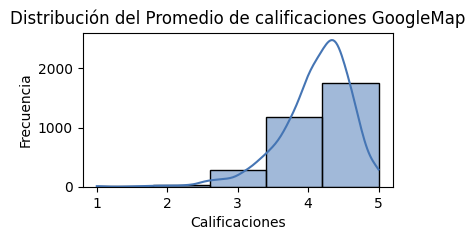

In [122]:
# Distribution of ratings
plt.figure(figsize=(4,2))
sns.histplot(df_gm_pizza_NJNY['avg_rating'], bins=5, kde=True, color='#4575b4')
plt.title("Distribución del Promedio de calificaciones GoogleMap")
plt.xlabel("Calificaciones")
plt.ylabel("Frecuencia")
plt.show()

Las posibles calificaciones estan en un rango de 1 a 5. Como mencionamos antes el promedio de calificaciones para las pizzerias de los estados de NJ y NY es de 4.11 +- 0.5 sugiriendo una tendencia positiva. </br>
Los locales tienen en promedio 89.9 reviews cada uno. Teniendo 1 review el que menos tiene y 4362 reviews el que tiene más.

In [ ]:
print('Estado de NJ: \n', df_gm_pizza_NJNY.loc[df_gm_pizza_NJNY['state'] == 'NJ', ['avg_rating', 'num_of_reviews']].describe() , '\n')
print('Estado de NY: \n', df_gm_pizza_NJNY.loc[df_gm_pizza_NJNY['state'] == 'NY', ['avg_rating', 'num_of_reviews']].describe())

Estado de NJ: 
         avg_rating  num_of_reviews
count  1134.000000     1134.000000
mean      4.116667       96.626984
std       0.499298      129.809335
min       1.000000        1.000000
25%       3.900000       33.000000
50%       4.200000       75.500000
75%       4.500000      128.000000
max       5.000000     2208.000000 

Estado de NY: 
         avg_rating  num_of_reviews
count  2118.000000     2118.000000
mean      4.106563       86.295090
std       0.513502      148.705217
min       1.000000        1.000000
25%       3.900000       18.000000
50%       4.200000       53.000000
75%       4.475000      108.000000
max       5.000000     4362.000000


Si discriminamos por estado vemos que para las pizzerias del estado de NJ el promedio de calificaciones es de 4.11 +- 0.49, similar al promedio de ambos estados. Y tienen un promedio de 96.6 reviews por local.</br>
Para el estado de NY el promedio de calificaciones es levemente menor 4.1 +- 0.5. Y los locales tienen en promedio 86.29 reviews cada uno.

In [89]:
# Pizza Hut o Pizza Hut Express
print('Estado de NJ: \n', df_gm_pizza_NJNY.loc[(df_gm_pizza_NJNY['state'] == 'NJ') & (df_gm_pizza_NJNY['business_name'].isin(['Pizza Hut', 'Pizza Hut Express'])), ['avg_rating', 'num_of_reviews']].describe() , '\n')
print('Estado de NY: \n', df_gm_pizza_NJNY.loc[(df_gm_pizza_NJNY['state'] == 'NY') & (df_gm_pizza_NJNY['business_name'].isin(['Pizza Hut', 'Pizza Hut Express'])), ['avg_rating', 'num_of_reviews']].describe())

Estado de NJ: 
        avg_rating  num_of_reviews
count   30.000000        30.00000
mean     3.303333        36.40000
std      0.580418        53.08133
min      1.700000         4.00000
25%      2.825000         8.00000
50%      3.400000        12.00000
75%      3.675000        28.00000
max      4.300000       225.00000 

Estado de NY: 
        avg_rating  num_of_reviews
count   58.000000       58.000000
mean     3.710345       76.017241
std      0.484384       86.060259
min      2.600000        1.000000
25%      3.425000       17.250000
50%      3.700000       37.500000
75%      3.975000      133.000000
max      5.000000      303.000000


Nuestro cliente, Pizza Hut, tiene un promedio de calificaciones de 3.3 en NJ y 3.7 en NY

In [28]:
# Las 10 pizzerías con mejor calificacion (mínimo 100 reviews)
top_pizza = df_gm_pizza_NJNY[df_gm_pizza_NJNY['num_of_reviews'] >= 100].sort_values(by='avg_rating', ascending=False).head(10)

# Las 10 pizzerías con menor calificacion (mínimo 100 reviews)
worst_pizza = df_gm_pizza_NJNY[df_gm_pizza_NJNY['num_of_reviews'] >= 100].sort_values(by='avg_rating', ascending=True).head(10)

print("Las 10 mejores pizzerías:\n", top_pizza[['business_name', 'avg_rating', 'num_of_reviews', 'state']], '\n')
print("Las 10 pizzerías con menor calificación:\n", worst_pizza[['business_name', 'avg_rating', 'num_of_reviews', 'state']])


Las 10 mejores pizzerías:
                          business_name  avg_rating  num_of_reviews state
149                   LEO'S PIZZERIA 🍕         4.9             118    NJ
1560          Villa di Como Ristorante         4.9             218    NY
2714                      Zevy's Pizza         4.9             126    NJ
658                   Topo Gigio Pizza         4.9             106    NJ
2304  GoodFellas pizzeria of SunnySide         4.9             488    NY
399                    Curioni's Pizza         4.9             138    NJ
1824                        Dough Vale         4.9             128    NY
1738               Kono Pizza Wildwood         4.8             108    NJ
738          Puterko's Family Pizzeria         4.8             118    NY
2237    Two Brothers Cafe and Pizzeria         4.8             116    NY 

Las 10 pizzerías con menor calificación:
           business_name  avg_rating  num_of_reviews state
972      Domino's Pizza         2.1             398    NY
520   Papa

Si clasificamos las pizzerias de acuerdo a su calificación observamos que las 10 pizzerias mejor calificadas son locales únicos, no pertenecen a una cadena, tienen un promedio entre 4.8 y 4.9 y hay 5 en el estado de NJ y 5 en NY. </br>
Respecto de las pizzerias peor calificadas se observa que su calificación está entre 2.1 y 2.7, pertenecen a dos cadenas muy conocidas (Domino's Pizza y  Papa John's Pizza) y 7 son del estado de NY.

In [ ]:
# Las 10 pizzerías con mejor calificacion (mínimo 50 reviews)
top_pizza = df_gm_pizza_NJNY[ (df_gm_pizza_NJNY['num_of_reviews'] >= 50) & (df_gm_pizza_NJNY['business_name'].isin(['Pizza Hut', 'Pizza Hut Express'])) ].sort_values(by='avg_rating', ascending=False).head(10)

# Las 10 pizzerías con menor calificacion (mínimo 50 reviews)
worst_pizza = df_gm_pizza_NJNY[(df_gm_pizza_NJNY['num_of_reviews'] >= 50) & (df_gm_pizza_NJNY['business_name'].isin(['Pizza Hut', 'Pizza Hut Express'])) ].sort_values(by='avg_rating', ascending=True).head(10)

print("Las 10 mejores pizzerías:\n", top_pizza[['business_name', 'avg_rating', 'num_of_reviews', 'state']], '\n')
print("Las 10 pizzerías con menor calificación:\n", worst_pizza[['business_name', 'avg_rating', 'num_of_reviews', 'state']])

Las 10 mejores pizzerías:
           business_name  avg_rating  num_of_reviews state
690           Pizza Hut         4.3             248    NY
2477          Pizza Hut         4.3              67    NY
3014          Pizza Hut         4.2              88    NY
3187          Pizza Hut         4.0             208    NY
2900          Pizza Hut         4.0             149    NY
1133          Pizza Hut         3.9             303    NY
2172          Pizza Hut         3.9              68    NJ
207   Pizza Hut Express         3.8             182    NY
2500          Pizza Hut         3.7             178    NY
2901          Pizza Hut         3.7             168    NY 

Las 10 pizzerías con menor calificación:
      business_name  avg_rating  num_of_reviews state
2625     Pizza Hut         2.7              54    NY
1196     Pizza Hut         2.9              68    NJ
1586     Pizza Hut         3.2              78    NY
829      Pizza Hut         3.2             148    NY
3081     Pizza Hut        

Para nuestro cliente , Pizza Hut, considerando los locales con mas de 50 reviews observamos que las pizzerias mejor calificadas tienen entre 3.7 y 4.3 de promedio y estan en su mayoria en NY. Y los locales de Pizza Hut peor calificados tienen en 2.7 y 3.5. Todos estan por encima del promedio y 6 de ellos estan en NY.

Cantidad de pizzerías con reviews GoogleMap por estado:
 state
NY    2118
NJ    1134
Name: count, dtype: int64


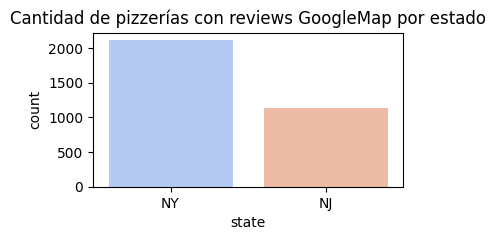

In [124]:
# Contar el número de pizzerías por estado
state_counts = df_gm_pizza_NJNY['state'].value_counts()

# Imprimir
print("Cantidad de pizzerías con reviews GoogleMap por estado:\n", state_counts)

plt.figure(figsize=(4,2))
sns.countplot(data=df_gm_pizza_NJNY, x="state", palette="coolwarm")
plt.title("Cantidad de pizzerías con reviews GoogleMap por estado")
plt.show()

Observamos que aparecen datos de 1134 pizzerias en NJ y de 2118 pizzerias en NJ

##### Analizaremos ahora los datos de reviews de Google Maps

In [7]:
df_gm_pizza_NJNY_rev['date'].agg(['min', 'max'])

min   2004-08-08 00:00:00.000
max   2021-09-02 18:56:09.765
Name: date, dtype: datetime64[ns]

Hay reviews de google maps desde 08/08/2004 hasta 02/09/2021. Por ahora no eliminaremos reviews antiguas. Revisamos la cantidad de reviews para cada año.

In [8]:
#  Extraer el año de la columna 'date'
df_gm_pizza_NJNY_rev['year'] = df_gm_pizza_NJNY_rev['date'].dt.year

# Contar el número de reseñas por año
reviews_per_year = df_gm_pizza_NJNY_rev['year'].value_counts().sort_index()

In [9]:
reviews_per_year.describe

<bound method NDFrame.describe of year
2004        2
2005        1
2006        7
2007        8
2008       11
2009       14
2010      101
2011      283
2012      378
2013      493
2014      529
2015     1482
2016     6200
2017    19018
2018    37075
2019    48237
2020    24303
2021    12516
Name: count, dtype: int64>

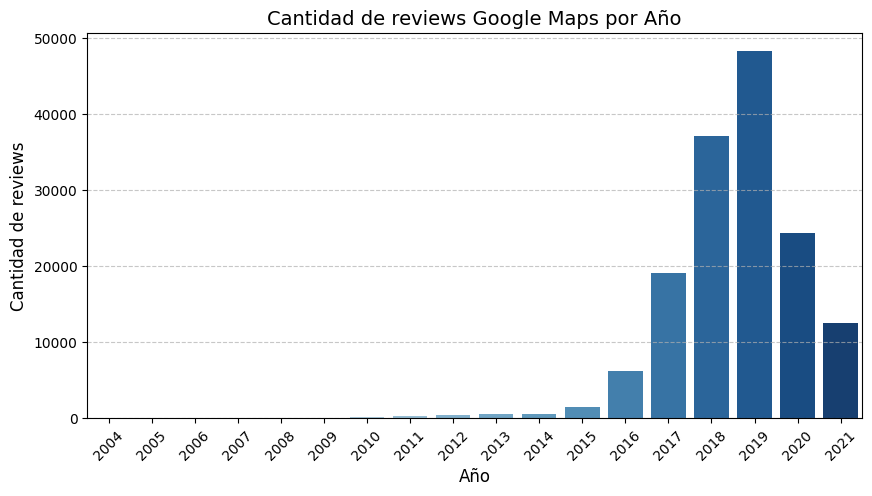

In [10]:
# Grafico la cantidad de reviews para cada año desde 2004 a 2021

plt.figure(figsize=(10, 5))
sns.barplot(x=reviews_per_year.index, y=reviews_per_year.values, palette='Blues')

plt.title('Cantidad de reviews Google Maps por Año', fontsize=14)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Cantidad de reviews', fontsize=12)
plt.xticks(rotation=45)  
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Observamos que hay mayor cantidad de reseñas a partir del año 2017. El año con más reseñas es 2019.

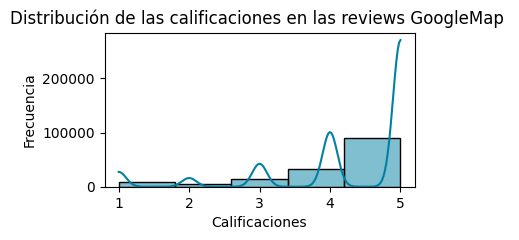

In [11]:
# Distribution of ratings
plt.figure(figsize=(4,2))
sns.histplot(df_gm_pizza_NJNY_rev['rating'], bins=5, kde=True, color='#0180a2')
plt.title("Distribución de las calificaciones en las reviews GoogleMap ")
plt.xlabel("Calificaciones")
plt.ylabel("Frecuencia")
plt.show()

En las reviews la mayoría de las pizzerías tienen calificaciones altas, entre 4 y 5.

In [12]:
pizzeria_stats = df_gm_pizza_NJNY_rev.groupby('business_name').agg(
    num_reviews=('rating', 'count'),  # Count reviews
    avg_rating=('rating', 'mean')  # Average rating
).reset_index()

top_pizzeria_stats = pizzeria_stats.sort_values(by='num_reviews', ascending=False).head(10)

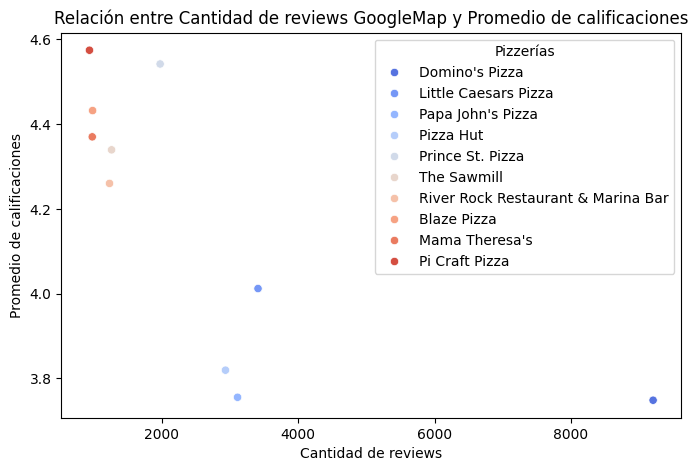

In [13]:
plt.figure(figsize=(8,5))
sns.scatterplot(data= top_pizzeria_stats, x="num_reviews", y="avg_rating", hue="business_name", palette="coolwarm")
plt.title("Relación entre Cantidad de reviews GoogleMap y Promedio de calificaciones")
plt.xlabel("Cantidad de reviews")
plt.ylabel("Promedio de calificaciones")
plt.legend(title="Pizzerías")
plt.show()

Podríamos decir que mayor cantidad de reviews indicaría mas popularidad. Pero pareciera que la relación entre cantidad de reviews y promedio de calificaciones sería inversamente proporcional. La calificación sería menor a mayor cantidad de reviews.

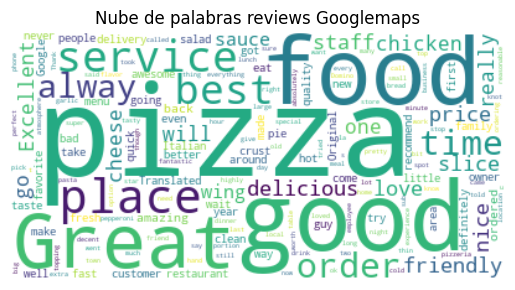

In [14]:
#Creating the text variable

df = df_gm_pizza_NJNY_rev.dropna(subset=['text'])

text2 = " ".join(text for text in df['text'])

# Creating word_cloud with text as argument in .generate() method
word_cloud2 = WordCloud(collocations = False, background_color = 'white').generate(text2)

# Display the generated Word Cloud
plt.imshow(word_cloud2, interpolation='bilinear')
plt.title(f"Nube de palabras reviews Googlemaps")
plt.axis("off")
plt.show()

Observamos la nube de palabras creada a partir de los textos de las reviews para todas las pizzerias. Se destacan palabras positivas como good, great, nice, friendly, nice, excellent

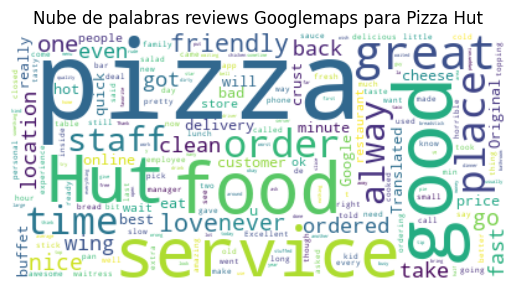

In [15]:
df_hut = df_gm_pizza_NJNY_rev[df_gm_pizza_NJNY_rev['business_name'].isin(['Pizza Hut', 'Pizza Hut Express'])]
df = df_hut.dropna(subset=['text'])

text2 = " ".join(text for text in df['text'])

# Creating word_cloud with text as argument in .generate() method
word_cloud2 = WordCloud(collocations = False, background_color = 'white').generate(text2)

# Display the generated Word Cloud
plt.imshow(word_cloud2, interpolation='bilinear')
plt.title(f"Nube de palabras reviews Googlemaps para Pizza Hut")
plt.axis("off")
plt.show()

Si analizamos solo los textos de las reviews para los locales de Pizza Hut vemos que se destacan palabras positivas como good, great y friendly, como en el gráfico anterior. Y que la palabra service aparece en mayor tamaño.

</br>

#### Datos de Yelp

El control de la calidad de los datos de los archivos de Yelp se hizo en las notebooks llamadas Yelp Business y Yelp Business Reviews. </br>
A continuación se detallarán brevemente los hallazgos. </br>

El dataframe yelp_academic_dataset_business tenia 150.346 filas. Se eliminarons las columnas "is_open", "attributes",  "hours" que no se usarán. 103 filas tenían valor nulo en la columna categories. Estas filas se descartaron cuando se seleccionaron filas de acuerdo al valor de esa columna.
Se seleccionaron 717 filas que tenian categoría 'pizza' y eran del estado de New Jersey. No hay datos de pizzerias que esten unicadas en el estado de New York. </br>
No se encontraron filas con valores duplicados. No se modificaron los tipos de datos. </br>
La columna star (calificación) tiene un rango de valores de 1.0 a 5.0. La media de calificación promedio es 3.4 . </br>
Se buscaron posibles outliers en la columna review_count. Se encontraron 3 locales con mas de 300 reseñas pero se supuso que eran valores posibles.</br>
Se eliminó la columna categories, luego de usarla.

El dataframe reviews de Yelp tiene 6.990.280 reviews. No tiene valores nulos para la columna text (con los comentarios de las reseñas) ni para la columna stars (con la calificacion). No hay filas con valores duplicados. Los tipos de datos no se modificaron. </br>
Este dataframe se unió con el de pizzerias para el departamento de NJ para conocer el nombre del local y los otros datos de cada pizzeria. </br>
Se encontraron 28.766 reseñas de Yelp para las pizzerias del estado de NJ. No hay filas con user_id nulo por lo que todas las pizzerias tendrían alguna review.</br>

In [16]:
# Leo los archivos con datos de Yelp
Yelp_pizza_NJ = pd.read_parquet('datos/yelp_yelp/yelp_pizza_NJ202502092108.parquet' , engine='fastparquet')
Yelp_pizza_NJ_rev = pd.read_parquet('datos/yelp_yelp/business_pizza_NJ_rev202502092150.parquet' , engine='fastparquet')

#### Análisis exploratorio de los datos de Yelp de pizzerías

In [86]:
print(Yelp_pizza_NJ[['stars' , 'review_count']].describe())

            stars  review_count
count  717.000000    717.000000
mean     3.403068     38.193863
std      0.757194     44.928467
min      1.000000      5.000000
25%      3.000000     13.000000
50%      3.500000     23.000000
75%      4.000000     46.000000
max      5.000000    390.000000


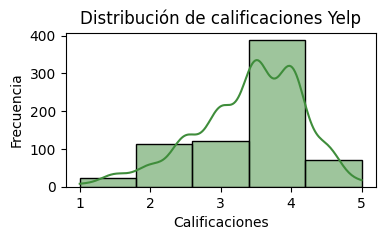

In [119]:
# Distribution of ratings
plt.figure(figsize=(4,2))
sns.histplot(Yelp_pizza_NJ['stars'], bins=5, kde=True, color='#3f8d3b')
plt.title("Distribución de calificaciones Yelp")
plt.xlabel("Calificaciones")
plt.ylabel("Frecuencia")
plt.show()

Las posibles calificaciones estan en un rango de 1 a 5. Como mencionamos antes el promedio de calificaciones para las pizzerias con reseñas de Yelp del estado de NJ 3.4 +- 0.75 sugiriendo una tendencia positiva. La mayoria de los locales tienen una calificación de alrededor de 4. </br>
Los locales tienen en promedio 38.2 reviews cada uno. Teniendo 5 review el que menos tiene y 390 reviews el que tiene más.

In [91]:
# Pizza Hut 
print('PIzza Hut: \n', Yelp_pizza_NJ.loc[Yelp_pizza_NJ['name'] == 'Pizza Hut', ['stars', 'review_count']].describe())

PIzza Hut: 
            stars  review_count
count  15.000000     15.000000
mean    2.000000     14.933333
std     0.566947      9.837731
min     1.500000      5.000000
25%     1.500000      6.500000
50%     2.000000     13.000000
75%     2.500000     19.500000
max     3.000000     36.000000


Nuestro cliente, Pizza Hut, tiene 15 locales en el estado de NJ con alguna review en Yelp. El promedio de reviews es 14.9 . El local con menos review tiene 5 y el local con mayor cantidad de reviews tiene 36. El promedio de calificaciones es 2. Es menor que el promedio que tiene en las reviews de Goglemaps que es 3.3 para el estado de NJ

In [92]:
# Las 10 pizzerías con mejor calificacion (mínimo 20 reviews)
top_pizza = Yelp_pizza_NJ[Yelp_pizza_NJ['review_count'] >= 20].sort_values(by='stars', ascending=False).head(10)

# Las 10 pizzerías con menor calificacion (mínimo 100 reviews)
worst_pizza = Yelp_pizza_NJ[Yelp_pizza_NJ['review_count'] >= 20].sort_values(by='stars', ascending=True).head(10)

print("Las 10 mejores pizzerías:\n", top_pizza[['name', 'stars', 'review_count']], '\n')
print("Las 10 pizzerías con menor calificación:\n", worst_pizza[['name', 'stars', 'review_count']])


Las 10 mejores pizzerías:
                                        name  stars  review_count
index                                                           
54727                Tigas Artisan Pizzeria    5.0            66
141025   Rocco's Pizza & Italian Restaurant    4.5            34
148779  Bukhara Restaurant & Tandoori Grill    4.5            85
14622     Francesco's Pizzeria & Ristorante    4.5            33
12385                           Pizza Crime    4.5            21
11204                       Liscio's Bakery    4.5            48
139015                     Jules Thin Crust    4.5            44
126067                    Marina’s Pizzeria    4.5            21
123816             Jim's Family Style Pizza    4.5            25
117217                        Benny's Pizza    4.5            25 

Las 10 pizzerías con menor calificación:
                            name  stars  review_count
index                                               
139990           Bella Pizza II    1.0     

Como ya habíamos observado en el análisis de los locales de google maps, si clasificamos las pizzerías de acuerdo a su calificación observamos que las 10 pizzerias mejor calificadas son locales únicos, no pertenecen a una cadena, tienen un promedio entre 4.5 y 5 stars. </br>
Respecto de las pizzerias peor calificadas se observa que su calificación está entre 1.0 y 2.0, 5 de los cuales pertenecen a cadenas como Domino's Pizza, Tony Soprano's Pizza y, lamentablemente, también Pizza Hut.

In [109]:
# Las 10 pizzerías con mejor calificacion (mínimo 10 reviews)
top_pizza = Yelp_pizza_NJ[(Yelp_pizza_NJ['review_count'] >= 10) & (Yelp_pizza_NJ['name'] == 'Pizza Hut')].sort_values(by='stars', ascending=False).head(10)

print("Los 10 locales Pizza Hut con mejores calificaciones:\n", top_pizza[['name', 'stars', 'review_count']])

Los 10 locales Pizza Hut con mejores calificaciones:
              name  stars  review_count
index                                 
130766  Pizza Hut    3.0            11
127518  Pizza Hut    2.5            33
31356   Pizza Hut    2.5            19
140113  Pizza Hut    2.0            20
44540   Pizza Hut    2.0            17
14878   Pizza Hut    1.5            22
41286   Pizza Hut    1.5            16
55472   Pizza Hut    1.5            13
142335  Pizza Hut    1.5            36


Para nuestro cliente, Pizza Hut, considerando los locales con más de 10 reviews observamos que las pizzerías de esta cadena tienen una calificación entre 1.5 y 3.0. Como hemos observado Google Maps tiene mayor cantidad de reseñas para Pizza Hut y con mejores calificaciones.

##### Analizaremos ahora los datos de reviews de Yelp

In [18]:
Yelp_pizza_NJ_rev['date'].agg(['min', 'max'])

min   2006-01-21 07:45:00
max   2022-01-19 19:05:53
Name: date, dtype: datetime64[ns]

Hay reviews de Yelp desde 21/01/2006 hasta 19/01/2022. Revisamos la cantidad de reviews para cada año.

In [ ]:
#  Extraer el año de la columna 'date'
Yelp_pizza_NJ_rev['year'] = Yelp_pizza_NJ_rev['date'].dt.year

# Contar el número de reseñas por año
Yelp_reviews_per_year = Yelp_pizza_NJ_rev['year'].value_counts().sort_index()

In [21]:
Yelp_reviews_per_year.describe

<bound method NDFrame.describe of year
2006      16
2007      48
2008     100
2009     170
2010     456
2011     788
2012    1166
2013    1632
2014    2243
2015    3054
2016    3421
2017    3541
2018    3448
2019    3543
2020    2565
2021    2467
2022     108
Name: count, dtype: int64>

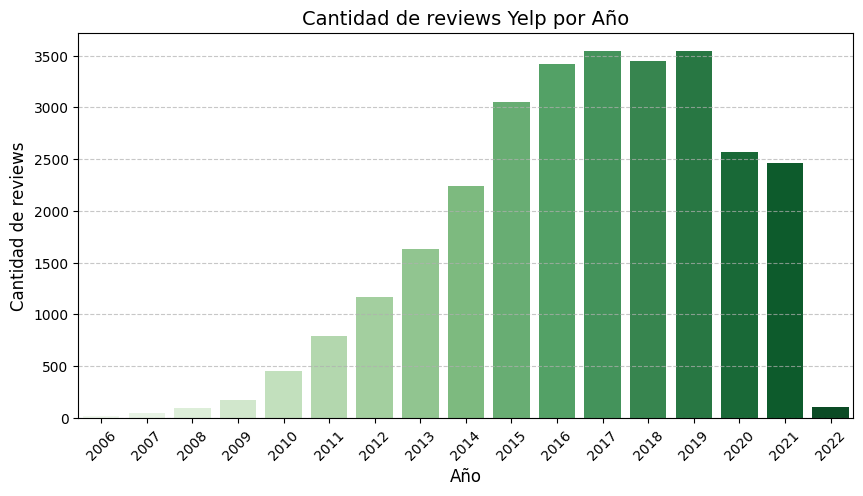

In [24]:
# Grafico la cantidad de reviews para cada año desde 2006 a 2022

plt.figure(figsize=(10, 5))
sns.barplot(x=Yelp_reviews_per_year.index, y=Yelp_reviews_per_year.values, palette='Greens')

plt.title('Cantidad de reviews Yelp por Año', fontsize=14)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Cantidad de reviews', fontsize=12)
plt.xticks(rotation=45)  
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Hay mayor cantidad de reseñas de Yelps a partir del año 2015. Disminuye la cantidad a partir de 2020. 

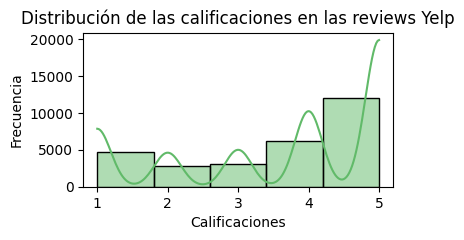

In [118]:
# Distribution of ratings
plt.figure(figsize=(4,2))
sns.histplot(Yelp_pizza_NJ_rev['stars_by_user'], bins=5, kde=True, color='#61ba69')
plt.title("Distribución de las calificaciones en las reviews Yelp")
plt.xlabel("Calificaciones")
plt.ylabel("Frecuencia")
plt.show()

Como sucedia con las reviews de GoogleMaps, en las reviews de Yelp la mayoría de las pizzerías tienen calificaciones altas, entre 4 y 5.

In [127]:
pizzeria_stats = Yelp_pizza_NJ_rev.groupby('name').agg(
    num_reviews=('stars_by_user', 'count'),  # Count reviews
    avg_rating=('stars_by_user', 'mean')  # Average rating
).reset_index()

top_pizzeria_stats = pizzeria_stats.sort_values(by='num_reviews', ascending=False).head(10)

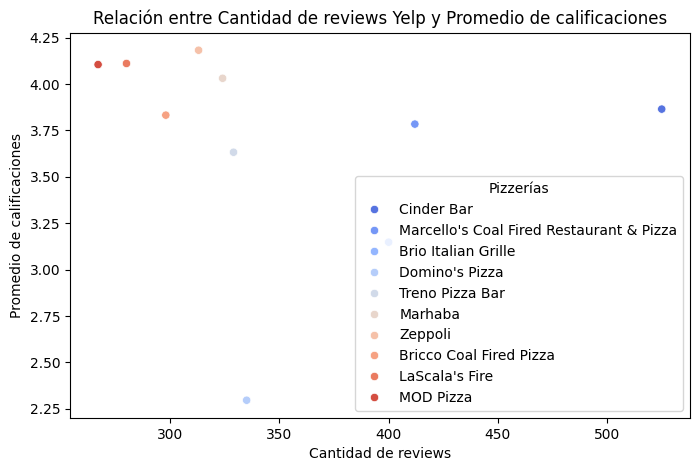

In [128]:
plt.figure(figsize=(8,5))
sns.scatterplot(data= top_pizzeria_stats, x="num_reviews", y="avg_rating", hue="name", palette="coolwarm")
plt.title("Relación entre Cantidad de reviews Yelp y Promedio de calificaciones")
plt.xlabel("Cantidad de reviews")
plt.ylabel("Promedio de calificaciones")
plt.legend(title="Pizzerías")
plt.show()

En el caso de Yelp podríamos decir que no se observa una correlación clara entre la cantidad de reviews y el promedio de calificaciones dados por cada usuario.

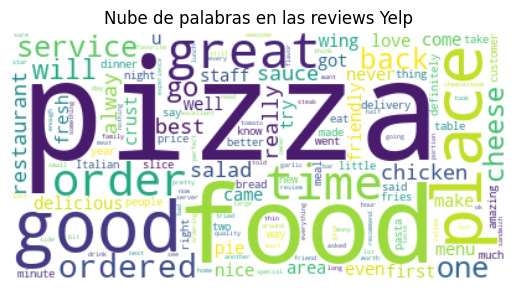

In [129]:
#Creating the text variable

df = Yelp_pizza_NJ_rev.dropna(subset=['text'])

text2 = " ".join(text for text in df['text'])

# Creating word_cloud with text as argument in .generate() method
word_cloud2 = WordCloud(collocations = False, background_color = 'white').generate(text2)

# Display the generated Word Cloud
plt.imshow(word_cloud2, interpolation='bilinear')
plt.title(f"Nube de palabras en las reviews Yelp")
plt.axis("off")
plt.show()

Observamos la nube de palabras creada a partir de los textos de las reviews para todas las pizzerias. Se destacan palabras positivas como good, great, service y delicious.  Podría haber menor variedad de palabras que en la nube de palabras de las reseñas de GoogleMpas porque la cantidad de reseñas analizadas es menor.

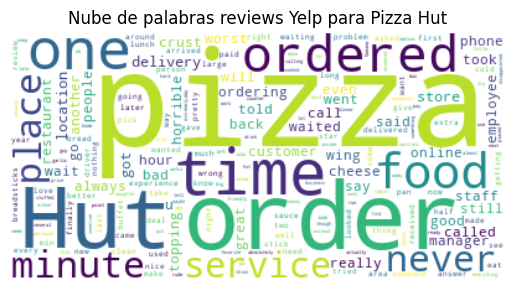

In [131]:
df_hut = Yelp_pizza_NJ_rev[Yelp_pizza_NJ_rev['name'] == 'Pizza Hut']
df = df_hut.dropna(subset=['text'])

text2 = " ".join(text for text in df['text'])

# Creating word_cloud with text as argument in .generate() method
word_cloud2 = WordCloud(collocations = False, background_color = 'white').generate(text2)

# Display the generated Word Cloud
plt.imshow(word_cloud2, interpolation='bilinear')
plt.title(f"Nube de palabras reviews Yelp para Pizza Hut")
plt.axis("off")
plt.show()

En la nube de palabras generada con los textos de las reviews de Yelp para los locales de Pizza Hut observamos algunas palabras positivas como service. Y otras que podrian ser negativas como never y called manager. Estos hallazgos podrian estar en relacion con las calificaciones entre 1.5 y 3para los locales de esta empresa que hemos observado. 